## VQ-VAE для упрощения работы conditional image2image

- https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
- Loss = vq_loss + MAE + PL_loss/1000
- best pixel loss: val_mae=0.0398 (or val_mse=0.0016)

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

    
def plot_samples_on_epoch(samples, nrow=8, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
        
def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    plt.grid()
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]
#----------------------------------------------------------------------------------------------------
        
# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0


## Instead of Data (for collaborators)

In [2]:
#df_train.to_csv('df_train.csv', index=False)
#df_val.to_csv('df_val.csv', index=False)
#d_train.to_csv('d_train.csv', index=False)
#d_val.to_csv('d_val.csv', index=False)

#df_train = pd.read_csv('df_train.csv')
#df_val = pd.read_csv('df_val.csv')
#d_train = pd.read_csv('d_train.csv') #.head(128)
#d_val = pd.read_csv('d_val.csv') #.head(128)

## Data

In [3]:
df = pd.read_csv('/media/laggg/surviv_rl_data/dataset_for_moving.csv')
dg = pd.read_csv('/media/laggg/surviv_rl_data/dataset_inventory_v2.csv')
m = []
d = []
for i in range(len(os.listdir('/media/laggg/surviv_rl_data/pickles'))):
    x = os.listdir('/media/laggg/surviv_rl_data/pickles')[i]
    name = x.split('.pi')[0]
    new_d = pickle.load(open("/media/laggg/surviv_rl_data/pickles/{}.pickle".format(name), "rb"))
    m.extend([new_d['mode']]*len(dg[dg.video == name]))
    d.extend(df[df.video == name].target.values.tolist())
dg['mode'] = np.array(m).astype(np.uint8)
dg['dir'] = np.array(d).astype(np.uint8)
dg = dg[dg['dir'] != 0] # убираем все кадры, где игрок стоит на месте (направление 0)

print(dg.shape)
#====================data split==============================================
videos = os.listdir('/media/laggg/surviv_rl_data/all_videoframes_gray/')
v_train, v_val = train_test_split(videos, test_size=0.1, random_state=42)

dg['train'] = dg['video'].apply(lambda x: 1 if x not in v_val else 0)
df_train = dg[dg['train'] == 1]
df_val = dg[dg['train'] == 0]
#============================================================================

print(dg.shape, df_train.shape, df_val.shape)
print('train:', np.unique(df_train['dir'], return_counts=True))
print('val:', np.unique(df_val['dir'], return_counts=True))

(1007275, 25)
(1007275, 26) (910423, 26) (96852, 26)
train: (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([115934,  96577, 141013,  98032, 115612, 104709, 139067,  99479]))
val: (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([13250, 10785, 15517,  9819, 11770, 10280, 14523, 10908]))


In [4]:
df_train = df_train.reset_index().drop(['index'], axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)

def make_dataset(df):
    s = df['dir'].values
    f = df['frame'].values
    zoom = df['zoom'].values
    n_seq = []
    f_seq = []
    n_max = []
    n = 0
    seq = []
    temp_seq = [0]
    a = s[0]
    for i in range(1,len(s)):
        x = s[i]
        if x == a and f[i-1]+1==f[i] and zoom[i]==1:
            temp_seq.append(i)
        else:
            if len(temp_seq)>=5:
                seq.append(temp_seq)
                n_seq.extend([n]*len(temp_seq[:-2]))
                f_seq.extend(temp_seq[:-2])
                n_max.extend([j for j in range(len(temp_seq[:-1]),1,-1)])
                n+=1
            temp_seq = [i]
            a = s[i]

    d = pd.DataFrame({'n_seq': n_seq, 'idx_seq': f_seq, 'n_max': n_max})
    #print(len(seq), len(d))
    return d, seq

d_train, seq = make_dataset(df_train)
d_val, _ = make_dataset(df_val)

## DataLoader

In [5]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p


class Surviv_Dataset(Dataset):
    def __init__(self,
                 dataset,
                 df,
                 augs=None):
        super().__init__()
        self.dataset = dataset
        self.df = df
        self.augs = augs
        self.dir_aug = np.array([[0,1,2,3,4,5,6,7,8], # real image
                                 [0,3,4,5,6,7,8,1,2], # rotate 90 o'clock
                                 [0,5,6,7,8,1,2,3,4], # rotate 180    
                                 [0,7,8,1,2,3,4,5,6], # rotate 270
                                 [0,1,8,7,6,5,4,3,2], # real image + gor flip
                                 [0,7,6,5,4,3,2,1,8], # rotate 90 o'clock + gor flip
                                 [0,5,4,3,2,1,8,7,6], # rotate 180 + gor flip
                                 [0,3,2,1,8,7,6,5,4]]) # rotate 270 + gor flip
  
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        i = self.dataset[idx][1]
        s0 = load_image(self.df[i][0], self.df[i][2])
        aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
        s0 = apply_aug(s0, aug)
        if self.augs is not None:
            s0 = self.augs(image=s0)['image']
        return s0

## Model

In [6]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
#===========================================================================================================

class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
#=============================================================================================

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)
#==========================================================================================================

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        self.act_last = nn.Tanh()

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)
        x = self._conv_trans_1(x)
        x = F.relu(x)
        x = self._conv_trans_2(x)
        x = self.act_last(x)
        return x
#=============================================================================================

class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, idx_qnt = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, idx_qnt

In [7]:
train_perplexity_ts = []
train_pl_loss_ts = []
train_pix_loss_ts = []
val_pix_loss_ts = []

  
def train_model(model,
                train_iterator, val_iterator,
                loss_func, optimizer,
                params):
    
    best_loss = 1000
    VGG = VGG_for_pl().to(params['DEVICE']).eval()
    MSE = nn.MSELoss()
    
    for i in range(params['EPOCHS']):
        
        #===========TRAIN=========================================
        time.sleep(0.2)
        model.train()
        train_pix_loss = 0.0     
        train_pl_loss = 0.0
        train_perplexity = 0.0
        for x in enumerate(tqdm(train_iterator)):
            data = x[1].to(params['DEVICE'])          
            optimizer.zero_grad()
            vq_loss, data_recon, perplexity = model(data)
            pix_loss_curr = loss_func(data_recon, data)
            #---PL-LOSS--------
            target_f = VGG(data)
            pred1_f = VGG(data_recon)
            pl_loss_curr = 0
            for ii in range(len(target_f)):
                pl_loss_curr = pl_loss_curr + MSE(pred1_f[ii], target_f[ii].detach())
            #------------------            
            train_pix_loss += pix_loss_curr.item()
            train_pl_loss += pl_loss_curr.item()
            train_perplexity += perplexity.item()
            loss = vq_loss + pix_loss_curr + pl_loss_curr/1000
            loss.backward()
            optimizer.step()

        train_pl_loss_ts.append(round(train_pl_loss / len(train_iterator),4))
        train_pix_loss_ts.append(round(train_pix_loss / len(train_iterator),4))
        train_perplexity_ts.append(round(train_perplexity / len(train_iterator),4))

        #===========VAL=================================================
        time.sleep(0.2)
        model.train(False)
        val_pix_loss = 0.0
        for x in enumerate(val_iterator):
            data = x[1].to(params['DEVICE'])            
            with torch.no_grad():
                vq_output_eval = model._pre_vq_conv(model._encoder(data))
                _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
                valid_reconstructions = model._decoder(valid_quantize)
            pix_loss_curr = loss_func(valid_reconstructions, data)
            val_pix_loss += pix_loss_curr.item()
            #-------------------------------------------------------
        val_pix_loss = round(val_pix_loss / len(val_iterator),4)
        val_pix_loss_ts.append(val_pix_loss)
        
        if val_pix_loss<best_loss:
            best_loss = val_pix_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'vqvae_v3.pth')         
        
        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'train_prplx:',   train_perplexity_ts[-1], '|',
              'train_PL:',   train_pl_loss_ts[-1],  '|',
              'train_pix:',  train_pix_loss_ts[-1], '|',
              'val_pix:',    val_pix_loss_ts[-1])

In [8]:
# for perceptual loss
class VGG_for_pl(nn.Module):
    
    def __init__(self, chosen_features=[0,5,10,19,28]):
        super().__init__()
        self.model = models.vgg19(pretrained=True).features
        self.chosen_features = chosen_features
        self.model_parts = []
        prev_layer = self.chosen_features[0]
        for i in range(len(self.chosen_features)):
            curr_layer = self.chosen_features[i]+1
            #print(prev_layer, curr_layer) #[0 1]; [1 6]; [6 11]; [11 20]; [20 29]
            self.model_parts.append(nn.Sequential(*(list(self.model.children())[prev_layer:curr_layer])))
            prev_layer = curr_layer
            
    def forward(self, x):
        features = []
        for part in self.model_parts:
            x = part(x)
            features.append(x)
        return features
#------------------------------------------------------------------------------------------------------------

m_params = {'num_hiddens': 128,
            'num_residual_hiddens': 32,
            'num_residual_layers': 2,
            'embedding_dim': 64,
            'num_embeddings': 512,
            'commitment_cost': 0.25,
            'decay': 0.99}

params = {'EPOCHS': 10,
          'DEVICE': 'cuda:0',
          'BATCH': 32}
    
train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                       ToTensorV2(transpose_mask=False),
                      ])

train_data = Surviv_Dataset(d_train.values, df_train.values, train_aug) #.head(128)
training_loader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)
test_data = Surviv_Dataset(d_val.values, df_val.values, train_aug) #.head(128)
validation_loader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)


model = Model(num_hiddens=m_params['num_hiddens'],
              num_residual_layers=m_params['num_residual_layers'],
              num_residual_hiddens=m_params['num_residual_hiddens'],
              num_embeddings=m_params['num_embeddings'],
              embedding_dim=m_params['embedding_dim'], 
              commitment_cost=m_params['commitment_cost'],
              decay=m_params['decay']).to(params['DEVICE'])

loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)

train_model(model,
            training_loader, validation_loader,
            loss_fn, optimizer,
            params)

100%|██████████| 2862/2862 [03:59<00:00, 11.95it/s]


1/10 train_prplx: 34.1093 | train_PL: 36.5391 | train_pix: 0.1531 | val_pix: 0.0652


100%|██████████| 2862/2862 [04:02<00:00, 11.78it/s]


2/10 train_prplx: 96.4462 | train_PL: 18.6183 | train_pix: 0.0698 | val_pix: 0.0549


100%|██████████| 2862/2862 [04:02<00:00, 11.82it/s]


3/10 train_prplx: 165.7947 | train_PL: 14.7425 | train_pix: 0.0607 | val_pix: 0.049


100%|██████████| 2862/2862 [04:02<00:00, 11.81it/s]


4/10 train_prplx: 221.149 | train_PL: 12.6591 | train_pix: 0.0552 | val_pix: 0.0456


100%|██████████| 2862/2862 [04:02<00:00, 11.81it/s]


5/10 train_prplx: 227.9907 | train_PL: 11.4657 | train_pix: 0.0522 | val_pix: 0.0434


100%|██████████| 2862/2862 [04:02<00:00, 11.80it/s]


6/10 train_prplx: 225.1266 | train_PL: 10.7212 | train_pix: 0.0504 | val_pix: 0.0422


100%|██████████| 2862/2862 [04:02<00:00, 11.80it/s]


7/10 train_prplx: 224.951 | train_PL: 10.1752 | train_pix: 0.0492 | val_pix: 0.0416


100%|██████████| 2862/2862 [04:02<00:00, 11.80it/s]


8/10 train_prplx: 223.5823 | train_PL: 9.7577 | train_pix: 0.0483 | val_pix: 0.0407


100%|██████████| 2862/2862 [04:02<00:00, 11.80it/s]


9/10 train_prplx: 222.3663 | train_PL: 9.4556 | train_pix: 0.0477 | val_pix: 0.0403


100%|██████████| 2862/2862 [04:02<00:00, 11.80it/s]


10/10 train_prplx: 221.7363 | train_PL: 9.2099 | train_pix: 0.0471 | val_pix: 0.0398


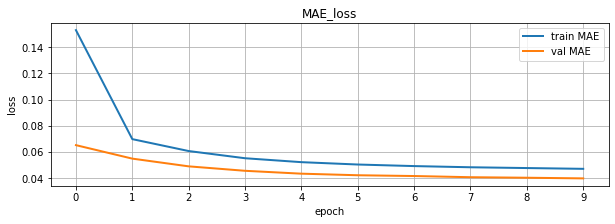

In [12]:
plt.figure(figsize=(10,3));
plt.plot(train_pix_loss_ts, label='train MAE', linewidth=2)
plt.plot(val_pix_loss_ts, label='val MAE', linewidth=2)
plt.title('MAE_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(params['EPOCHS']))
plt.legend()
plt.grid()
plt.show();

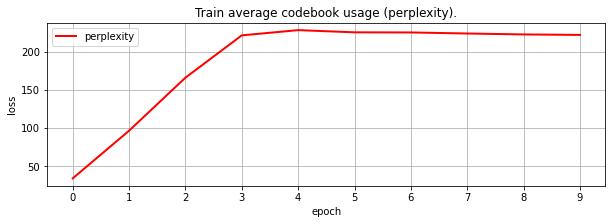

In [13]:
plt.figure(figsize=(10,3));
plt.plot(train_perplexity_ts, label='perplexity', color='red', linewidth=2)
plt.title('Train average codebook usage (perplexity).')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(params['EPOCHS']))
plt.legend()
plt.grid()
plt.show();

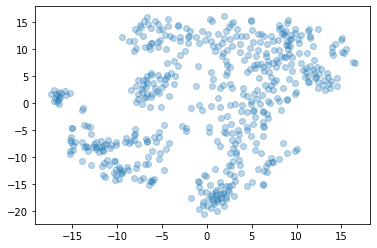

In [16]:
# Codebook embeddings
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

X = model._vq_vae._embedding.weight.data.cpu()
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)

TSNE_model = TSNE(metric="precomputed", square_distances=True)
Xpr = TSNE_model.fit_transform(distance_matrix)
plt.scatter(Xpr[:,0], Xpr[:,1], alpha=0.3);

## Validation

In [7]:
# DATA
params = {'EPOCHS': 10,
          'DEVICE': 'cuda:0',
          'BATCH': 32}

train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                       ToTensorV2(transpose_mask=False),
                      ])
train_data = Surviv_Dataset(d_train.values, df_train.values, train_aug) #.head(128)
training_loader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)
test_data = Surviv_Dataset(d_val.values, df_val.values, train_aug) #.head(128)
validation_loader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)

# MODEL
m_params = {'num_hiddens': 128,
            'num_residual_hiddens': 32,
            'num_residual_layers': 2,
            'embedding_dim': 64,
            'num_embeddings': 512,
            'commitment_cost': 0.25,
            'decay': 0.99}
model = Model(num_hiddens=m_params['num_hiddens'],
              num_residual_layers=m_params['num_residual_layers'],
              num_residual_hiddens=m_params['num_residual_hiddens'],
              num_embeddings=m_params['num_embeddings'],
              embedding_dim=m_params['embedding_dim'], 
              commitment_cost=m_params['commitment_cost'],
              decay=m_params['decay'])
model.load_state_dict(torch.load('./best_models/vqvae_v3.pth'))
model = model.to(device).to(params['DEVICE'])

In [8]:
model.eval()

valid_originals = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, idx_qnt = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

gt = valid_originals.data.permute(0,2,3,1).detach().cpu().numpy()
pred = valid_reconstructions.permute(0,2,3,1).detach().cpu().numpy()
h = int(np.sqrt(idx_qnt.size()[0]/params['BATCH']))
idx_v = torch.argmax(idx_qnt.view(params['BATCH'],h,h,m_params['num_embeddings']), 3).detach().cpu().numpy()

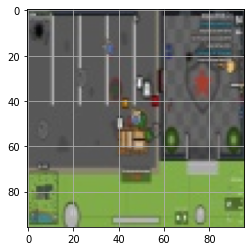

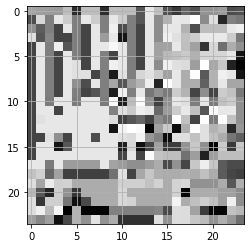

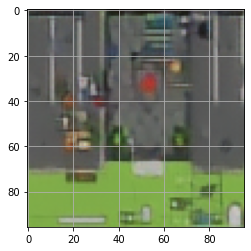

In [9]:
for k in range(15,16):
    p_gt = (gt[k]+1)/2
    p_pred = (pred[k]+1)/2
    p_idx = idx_v[k]
    see_plot(p_gt, size=(4,4))
    see_plot(p_idx, size=(4,4))
    
valid_quantize = torch.roll(valid_quantize, (0,0,0,-6), (0,1,2,3)) # сдвиг в пространстве индексов векторов
valid_reconstructions = model._decoder(valid_quantize) # расдекоживание сдвинутых индексов векторов

k = 15
pred = valid_reconstructions.permute(0,2,3,1).detach().cpu().numpy()
p_pred = (pred[k]+1)/2
see_plot(p_pred, size=(4,4))

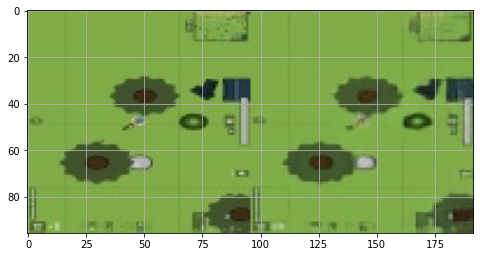

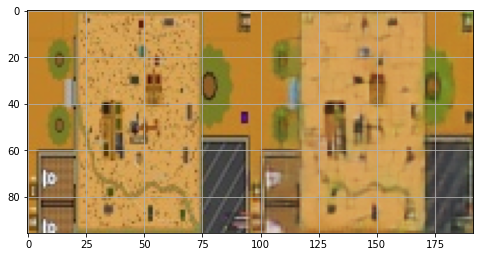

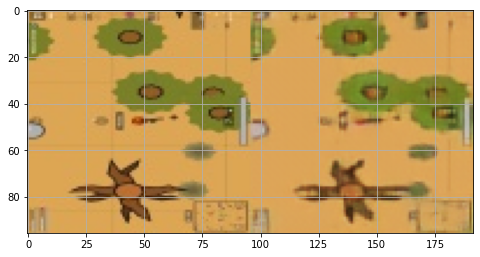

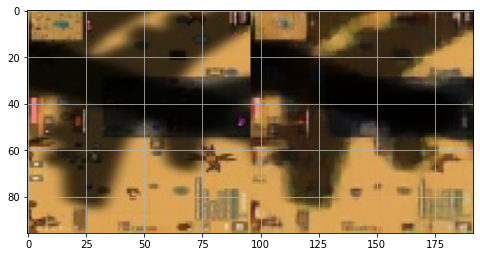

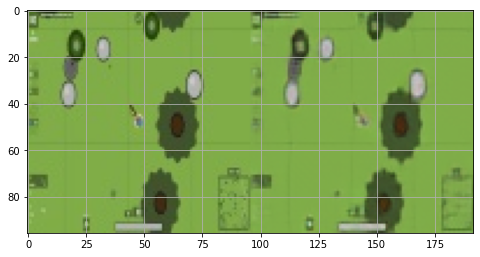

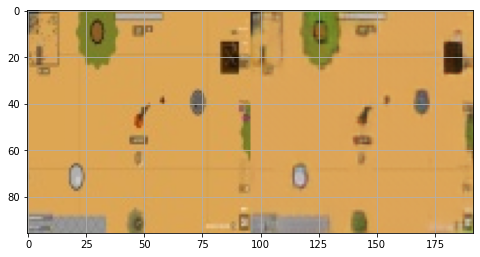

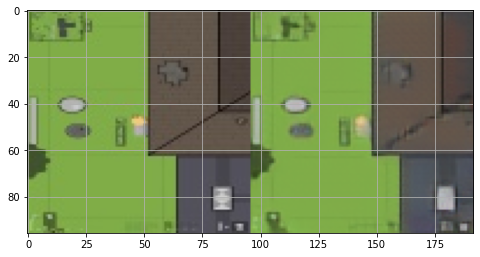

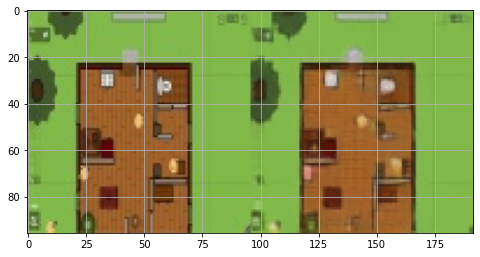

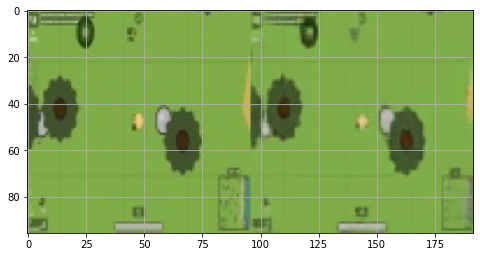

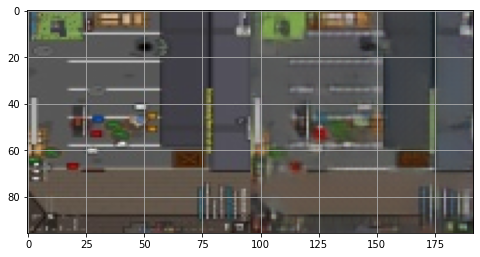

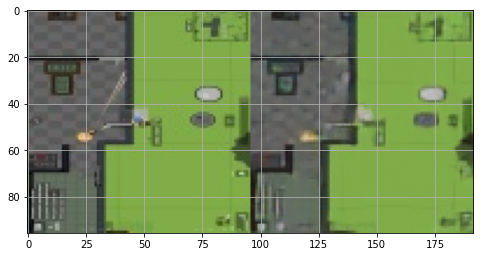

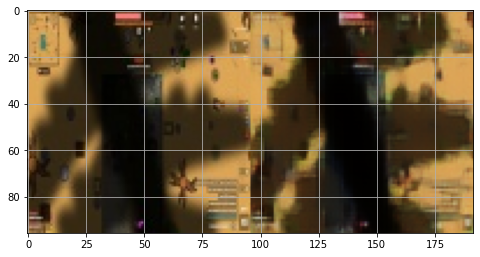

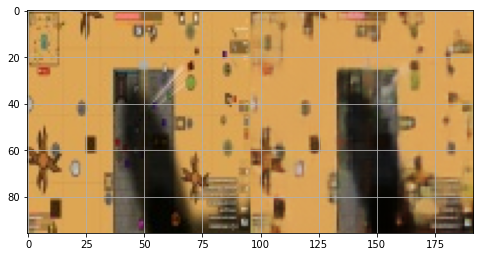

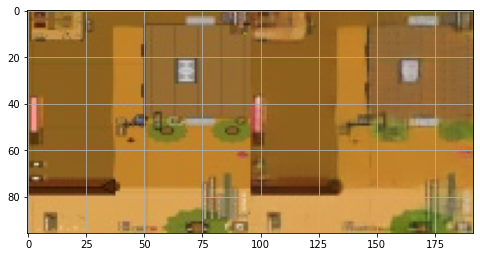

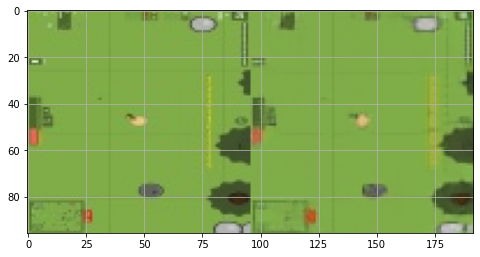

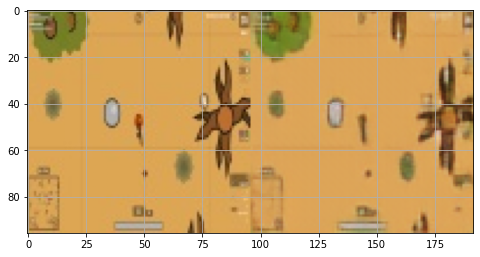

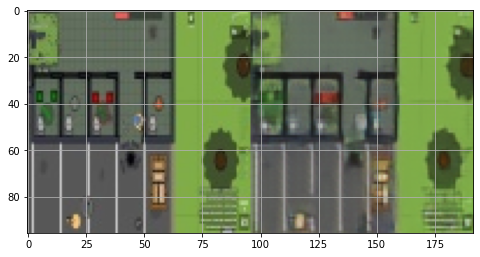

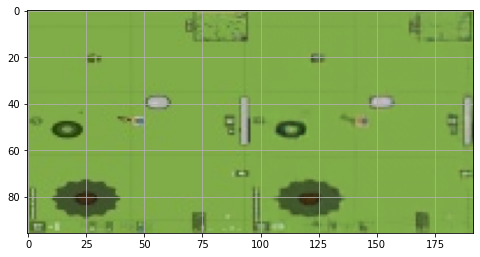

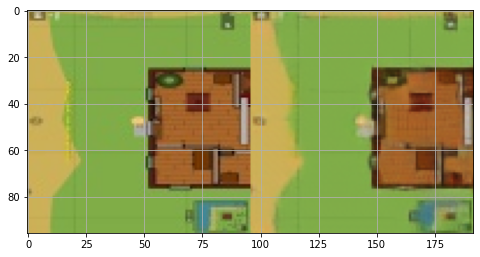

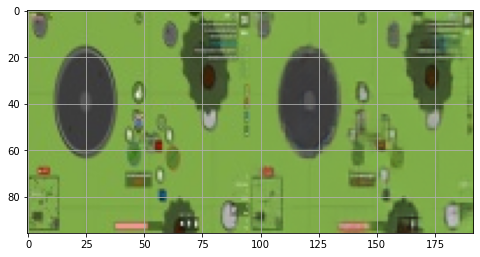

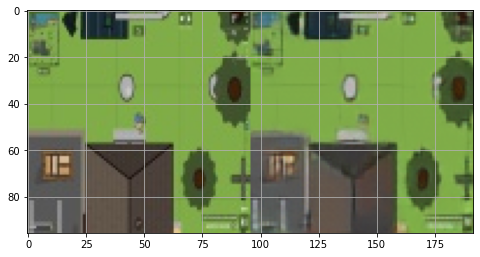

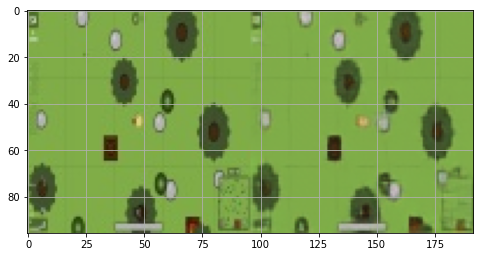

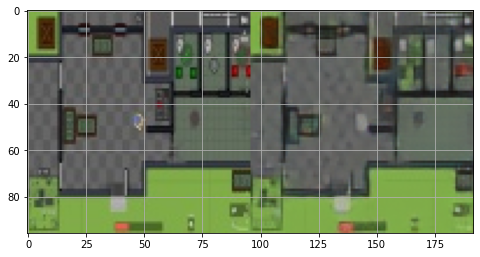

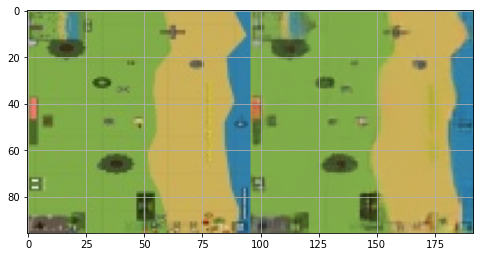

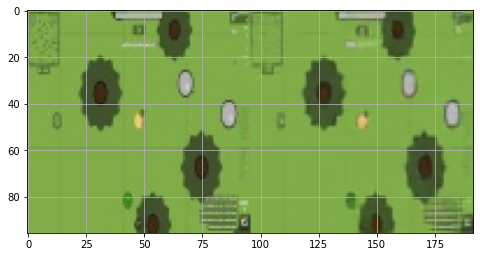

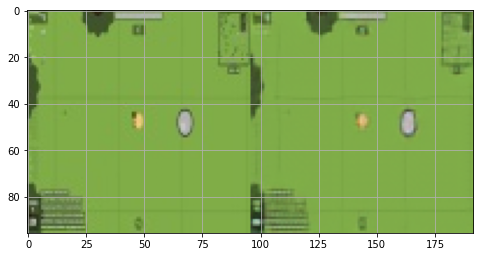

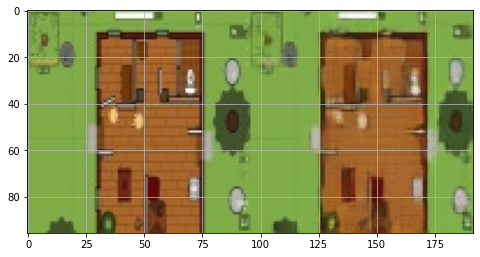

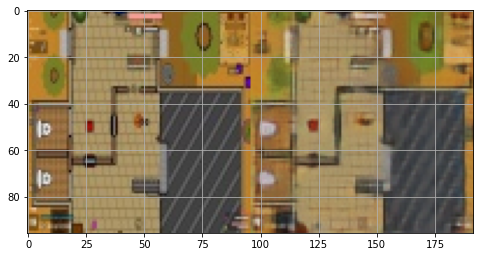

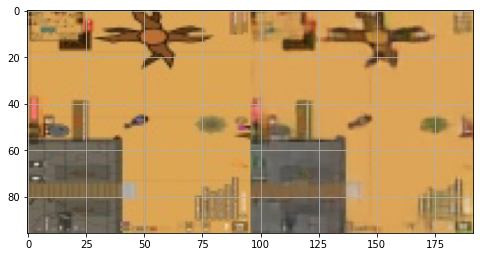

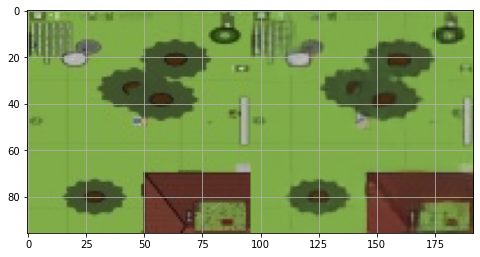

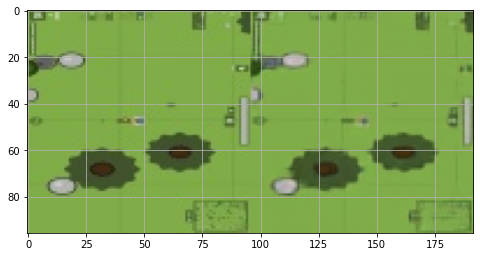

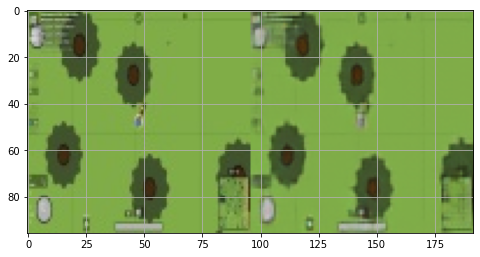

In [22]:
for k in range(32):
    p_gt = (gt[k]+1)/2
    p_pred = (pred[k]+1)/2
    see_plot(np.concatenate([p_gt,p_pred], axis=1), (8,8))